<a href="https://colab.research.google.com/github/embr-boyc/Astro-Data/blob/main/Gravitational_Waves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install gwpy #installs the gwpy package, used for analyzing gravitational waves

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.4 MB/s eta 0:00:00
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp310-cp310-linux_x86_64.whl size=99225 sha256=fb16eb5d8b78a211066d8f30cbccf12ad1301342318afce4e59000dff7bcec2d
  Stored in directory: /root/.cache/pip/wheels/6d/48/d1/3466977be4e41ba57f92ad0d5619f083df43cf319a151c4e06
Successfully built ligo-segments


In [100]:
# # -- Set a GPS time:
t1 = 1267963151.3   # -- GW200311_115853 Sets a specific GPS time for reference
# t0 = 1187008882.4    # -- GW170817

from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('H1', 1267963145, 1267963165) # Fetches data from H1 over a certian time interval

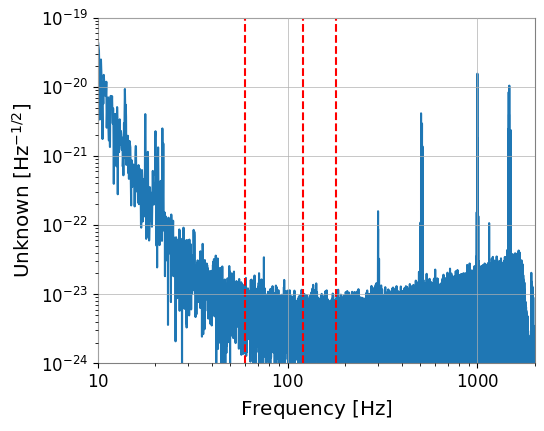

In [101]:
import matplotlib.pyplot as plt # Imports package for plotting

# -- Plot ASD (plots the amplitude spectral density)
fig2 = hdata.asd().plot()
plt.xlim(10,2000) # Frequency range (Hz)
ymin = 1e-24 # Minimum value of y-axis
ymax = 1e-19 # Maximum value of y-axis
plt.ylim(ymin, ymax)
plt.vlines(60, ymin, ymax, linestyle="dashed", color="red") # Common electrical noise frequency
plt.vlines(120, ymin, ymax, linestyle="dashed", color="red") # Common electrical noise frequency
plt.vlines(180, ymin, ymax, linestyle="dashed", color="red") # Common electrical noise frequency

In [102]:
from gwpy.signal import filter_design
bp = filter_design.bandpass(50, 250, hdata.sample_rate) # Bandpass filter for frequencies between 50 and 250 Hz

notches = [filter_design.notch(line, hdata.sample_rate) for # Notch filter for frequencies between 60, 120, and 180 Hz to remove specific noise frequencies from the data
           line in (60, 120, 180)]

zpk = filter_design.concatenate_zpks(bp, *notches) # Combines bandpass and notch filters

hfilt = hdata.filter(zpk, filtfilt=True) # Applies the combined filter to hdata

In [103]:
hdata = hdata.crop(*hdata.span.contract(1)) # Crops original and filtered data by 1 second on each side to eliminate edge effects
hfilt = hfilt.crop(*hfilt.span.contract(1))

In [104]:
print(*hdata.span.contract(1)) # Prints start and end times of the cropped origional data

1267963147.0 1267963163.0


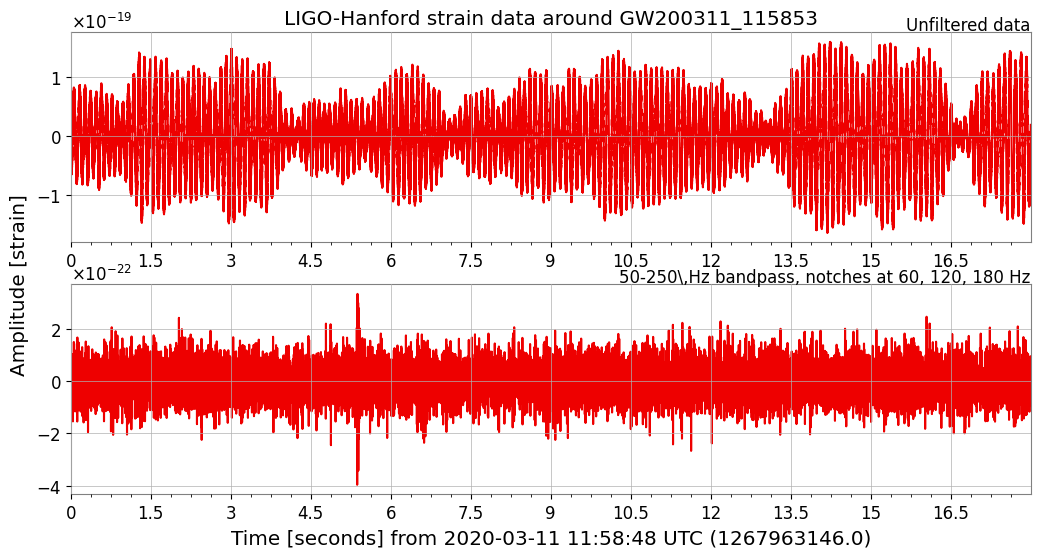

In [121]:
from gwpy.plot import Plot # Imports plot package from gwpy package
plot = Plot(hdata, hfilt, figsize=[12, 6], separate=True, sharex=True, # Plots original and filtered data on separate subplots
            color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW200311_115853')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()

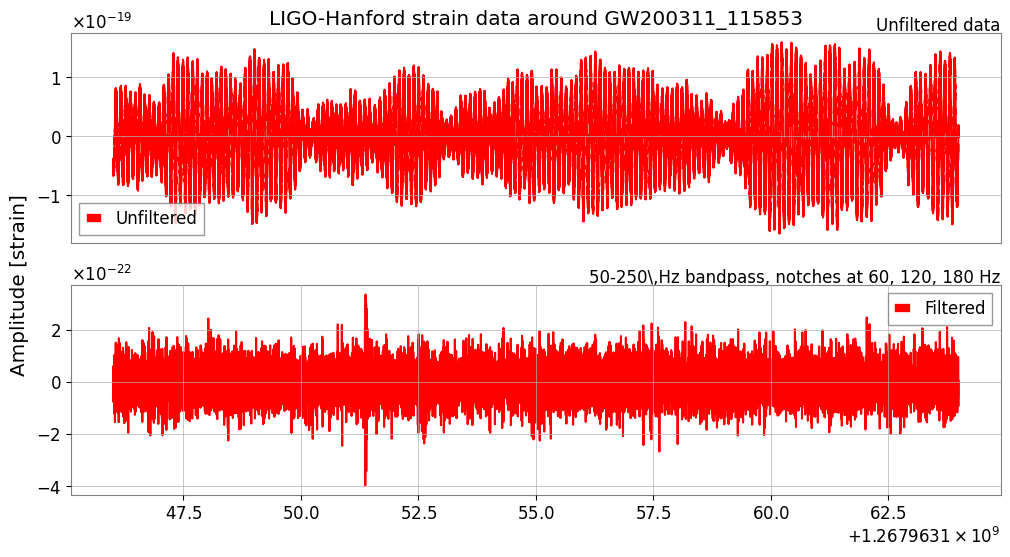

In [122]:
plt.figure(figsize=[12, 6]) # Plots original and filtered data on separate subplots (without gwpy package)
ax1 = plt.subplot(2, 1, 1)
ax1.plot(hdata.times.value, hdata.value, color="red", label="Unfiltered")
plt.legend()
ax1.set_title('LIGO-Hanford strain data around GW200311_115853')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.xaxis.set_visible(False)
ax2 = plt.subplot(2, 1, 2)
ax2.plot(hfilt.times.value, hfilt.value, color="red", label="Filtered")
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plt.legend()

In [107]:
hdata.value # Accesses strain data values

array([-4.88823928e-20, -4.20975719e-20, -3.81923594e-20, ...,
        2.93759761e-21,  1.39208296e-20,  1.85310108e-20])

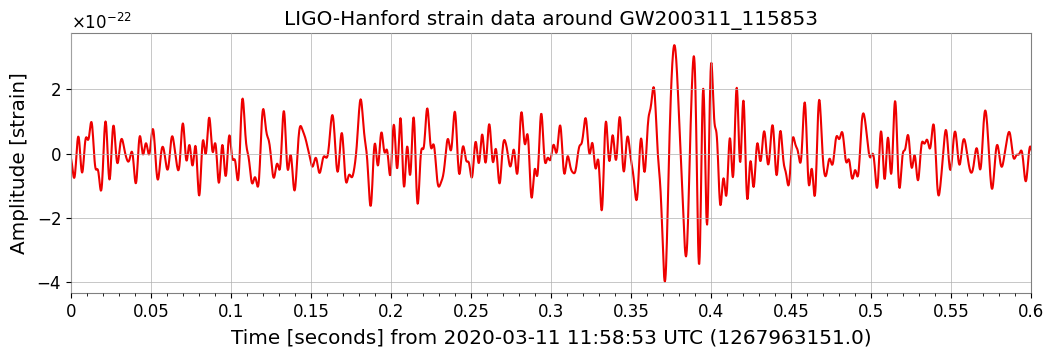

In [123]:
import matplotlib.pyplot as plt # Import matplot for plotting

plot = hfilt.plot(color='gwpy:ligo-hanford') # Plots the filtered data hfilt with a limited time range around the event
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW200311_115853')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(1267963151, 1267963151.6) # Time interval
ax.set_xscale('seconds', epoch=1267963151)
plot.show()

x_val = plt.gca().lines[0].get_xdata() # x data from prevoius graph
y_val = plt.gca().lines[0].get_ydata() # y data from prevoius graph

In [110]:
ldata = TimeSeries.fetch_open_data('L1', 1267963145, 1267963165) # Fetches L1 data from the same event
lfilt = ldata.filter(zpk, filtfilt=True) # Applies same filter

In [111]:
lfilt.shift('6.9ms') # Time-shifts lfilt by 6.9 milliseconds and inverts it to align with hfilt
lfilt *= -1 #  Inverts it to align with hfilt

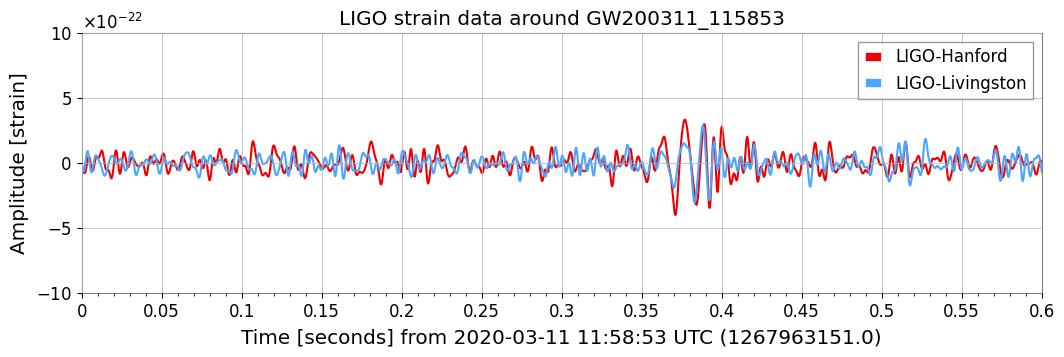

In [124]:
plot = Plot(figsize=[12, 4]) # Plots hfilt and lfilt on same axis for comparison
ax = plot.gca()
ax.plot(hfilt, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(lfilt, label='LIGO-Livingston', color='gwpy:ligo-livingston')
ax.set_title('LIGO strain data around GW200311_115853')
ax.set_xlim(1267963151, 1267963151.6) # Time interval
ax.set_xscale('seconds', epoch=1267963151)
ax.set_ylabel('Amplitude [strain]')
ax.set_ylim(-1e-21, 1e-21)
ax.legend()
plot.show()

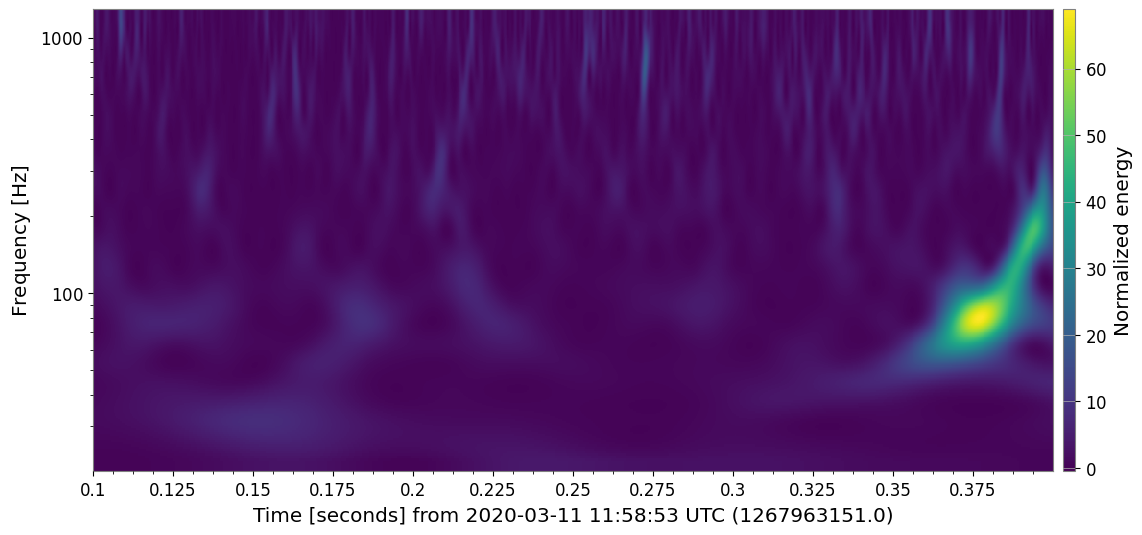

In [113]:
dt = 0.2  #-- Set width of q-transform plot, in seconds
hq = hfilt.q_transform(outseg=(t1-dt, t1+0.1)) # Calculates q-transform of hfilt for a specified time range
fig4 = hq.plot()
ax = fig4.gca()
fig4.colorbar(label="Normalized energy")
ax.grid(False)
ax.set_yscale('log') # Plotting a spectrogram with a logarithmic y-scale

In [114]:
from scipy.io.wavfile import write # Imports a .wavfile from write package
import numpy as np # Imports numpy for calculations

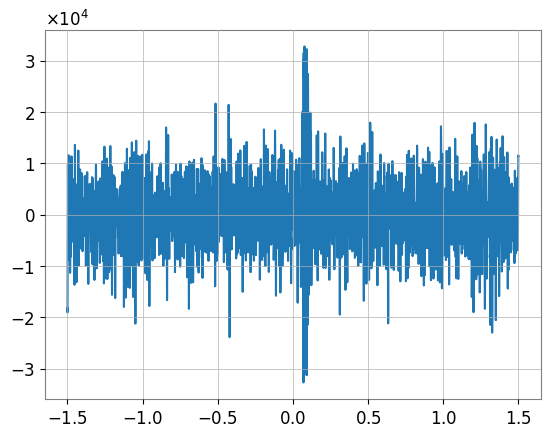

In [115]:
amplitude = np.iinfo(np.int16).max

ind = np.where((x_val < (t1+1.5)) & (x_val > (t1-1.5))) # Extracts a section of data
y = y_val[ind] # y = y**3
y = y / np.max(y)
plt.plot(x_val[ind] - t1, (np.array(y) * amplitude).astype(np.int16))

In [116]:
fs = int(1 / np.median(np.diff(np.array(x_val[ind] - t1)))) # Computed sampling rate
print("fs = ", fs)
write("example.wav", fs, (np.array(y) * amplitude).astype(np.int16))

fs =  4096
